In [1]:
import tensorflow as tf
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from datetime import datetime
from functools import reduce
from tensorflow import keras
from tensorflow.keras.datasets import mnist

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping

### Load MNIST dataset

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

format dataset as square images or as matrices so we can use convolutional layers

In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


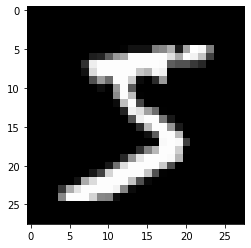

In [4]:
plt.figure()
plt.imshow(x_train[0, :, :, 0], cmap='gray')

In [6]:
BATCH_SIZE = 10
img_width = x_train.shape[1]
img_height = x_train.shape[2]
channels = x_train.shape[3] # images are in black and white, for RGB we have 3 channels (r,g,b)

### Now we define the Convolutional Autoencoder - CAE

```
input --> encoder --> latent_space --> decoder --> reconstructed_image
input_img              encoder output                 decoded_output
```

In [13]:
conv_shape = (3, 3)

In [17]:
input_img = Input(shape=(img_width, img_height, channels))
x = Conv2D(16, conv_shape, activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, conv_shape, activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded')(x)

In [18]:
x = Conv2D(8, conv_shape, activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, conv_shape, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(channels, conv_shape, activation='sigmoid', padding='same')(x)

dimensionality reduction?

In [19]:
img_height * img_width / int(reduce(lambda x, y: x*y, np.asarray(encoded.shape[1:])))

2.0

In [22]:
encoder = Model(input_img, encoded, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
encoded (MaxPooling2D)       (None, 7, 7, 8)           0         
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [24]:
autoencoder = Model(input_img, decoded, name='convolutional_autoencoder')
autoencoder.compile(optimizer='adadelta', loss='mse')
autoencoder.summary()

Model: "convolutional_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
encoded (MaxPooling2D)       (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 1

#### callbacks

We are going to use early stopping and reduce lr on pateau callbacks to avoid improve the generalization of the model and avoid overfitting.

Also we are going to add the tensorboard callback to check the training losses during the training process.

In [25]:
log_dir = "./logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tb_cb = TensorBoard(
    log_dir=log_dir, 
    profile_batch=0)

es_cb = EarlyStopping(
    monitor='val_loss',
    verbose=True,
    patience=12,
    min_delta=0.0001, 
    restore_best_weights=True)

lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    verbose=True,
    patience=8,
    mi_delta=0.0001)

cb = [tb_cb, es_cb, lr_cb]

Since the target in an autoencoder is the same as the input, both `x` and `y` are the same here.

In [42]:
epochs = 20

autoencoder_train = autoencoder.fit(
    x=x_train, 
    y=x_train,
    epochs=epochs, 
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=cb)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 8s 128us/sample - loss: 0.0333 - val_loss: 0.0324
Epoch 2/20
60000/60000 [==============================] - 8s 128us/sample - loss: 0.0322 - val_loss: 0.0314
Epoch 3/20
60000/60000 [==============================] - 8s 128us/sample - loss: 0.0312 - val_loss: 0.0305
Epoch 4/20
60000/60000 [==============================] - 8s 127us/sample - loss: 0.0304 - val_loss: 0.0297
Epoch 5/20
60000/60000 [==============================] - 8s 128us/sample - loss: 0.0297 - val_loss: 0.0290
Epoch 6/20
60000/60000 [==============================] - 8s 128us/sample - loss: 0.0291 - val_loss: 0.0284
Epoch 7/20
60000/60000 [==============================] - 8s 128us/sample - loss: 0.0285 - val_loss: 0.0279
Epoch 8/20
60000/60000 [==============================] - 8s 128us/sample - loss: 0.0280 - val_loss: 0.0273
Epoch 9/20
60000/60000 [==============================] - 8s 128us/sample - loss: 0.02

In [27]:
saved = False
if not saved:
    autoencoder.save('./cae_model_{}.hdf5'.format(epochs))
    encoder.save('./cae_encoder_{}.hdf5'.format(epochs))    
    saved = True

### Visualize autoencoder results

We choose ten random images from the testing dataset

In [43]:
ind_test = np.random.choice(range(x_test.shape[0]), 10)

In [44]:
test_images = np.take(x_test, ind_test, axis=0)
preds = autoencoder.predict(test_images)

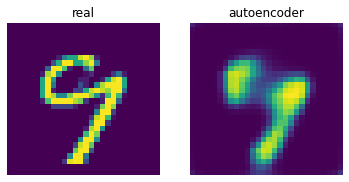

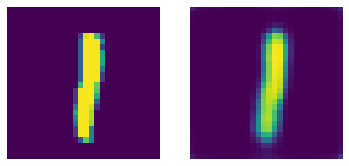

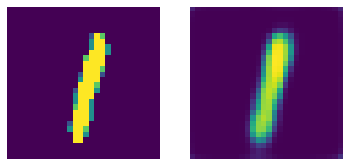

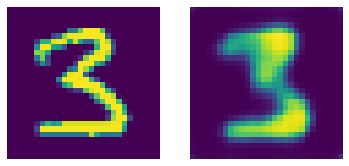

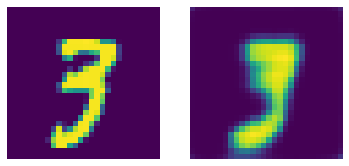

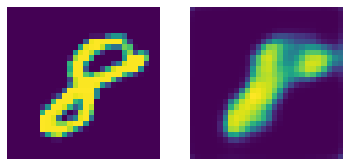

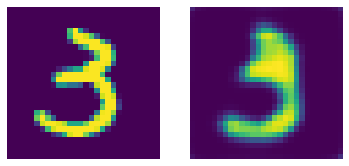

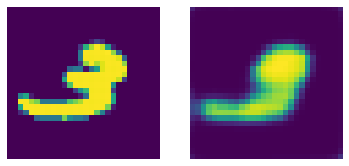

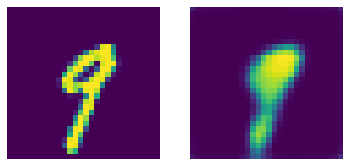

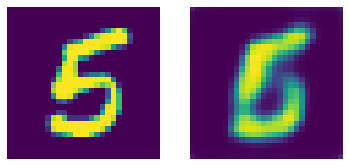

In [45]:
has_title = False
for im, pred in zip(test_images, preds):
    plt.figure()
    
    ax1 = plt.subplot(1,2,1)
    plt.imshow(np.squeeze(im))
    
    ax2 = plt.subplot(1,2,2)
    plt.imshow(np.squeeze(pred))
    
    ax1.axis('off')
    ax2.axis('off')    
    if not has_title:
        ax1.set_title('real')
        ax2.set_title('autoencoder')
        has_title = True

### Latent space visualization

In this particular case since we are using a very simple convolutional netwok the different dimensions of the latent space are going to look very similar to the input.

Probably are edge detections and directions filters.

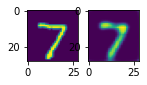

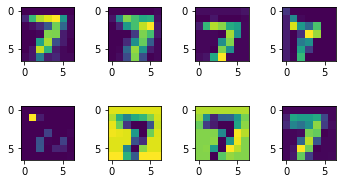

In [48]:
def plot_latents(input_image):
    test_ar = input_image
    pred = autoencoder.predict(test_ar)
    
    for real, coded in zip(test_ar, pred):
        plt.figure(figsize = (2,4))
        plt.subplot(1,2,1)
        plt.imshow(real[:,:,0])
        plt.subplot(1,2,2)
        plt.imshow(coded[:,:,0])   
    
    coded_image = encoder.predict(test_ar)
    coded_dims = coded_image.shape[-1]

    plt.figure(figsize = (5,3))
    for i in range(coded_dims):
        plt.subplot(int(np.ceil(coded_dims)/4),4, i+1)
        plt.imshow(coded_image[0, :, :, i])
    plt.tight_layout()    
    
    return pred, coded_image

_ ,_ = plot_latents(x_test[0:1,:,:,:])

### More latent space visualizations - TSNE

TSNE uses 2d data as input, so we reshape the data from 4d to 2d.
Then we apply TSNE for dimensionality reduction Nsamples, Nd --> Nsamples, 2 dimensions

In [49]:
latent = encoder.predict(x_test)

In [50]:
latent_1d = np.reshape(latent,  (latent.shape[0], int(reduce(lambda x, y: x*y, np.asarray(latent.shape[1:])))))

In [54]:
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import silhouette_score
import pandas as pd

In [57]:
latent_tsne = TSNE(n_components=2, random_state=2).fit_transform(latent_1d)
latent_data = pd.DataFrame({
        'x': latent_tsne[:, 0],
        'y': latent_tsne[:, 1],
        'label': y_test})

score: 0.3587394654750824


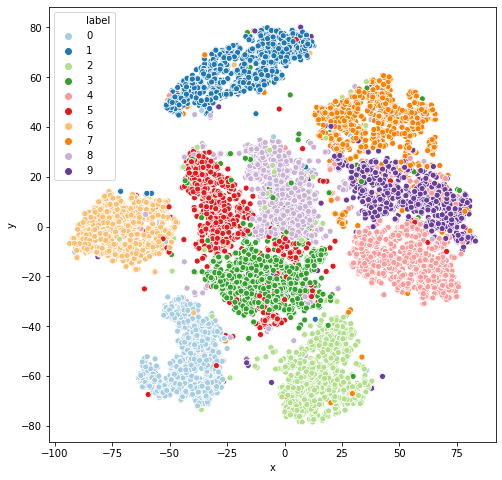

In [58]:
print('score: {}'.format(silhouette_score(latent_tsne, latent_data['label'] )))
fig = plt.figure(figsize=(8, 8))
ax = sns.scatterplot(x='x', y='y', hue='label', data=latent_data, palette='Paired')